In [3]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
import cPickle as pickle
import data_generator as dg
import multiscale_detect as md
import kmeansutil as ku
import non_maximum_suppression as nms
import utils as ut
from scipy import ndimage
%matplotlib inline  

Get data array from generate_data module. Randomize the array. Pick sample_size amount from each

Data is stored in a pickled zipped list of features and labels

In [5]:
#get positive images, determine best ratios (rows over columns), assign to images

pimages = dg.getImagesFromJSON(open("labels.json").read())

clusters, images = ku.addClusterLabels(pimages)
ratios = [r[0] for r in clusters]
print ratios

[0.46285263035703317, 1.1003667227651768, 0.77338458477358618]


Separate positive images into aspect ratios, get negative images and crop to aspect ratios

In [6]:
print ndimage.rotate(images[0][0], 5).shape

(145, 253, 3)


In [7]:

def get_mods(img):    
    results = []
    results.extend([ndimage.rotate(img, 2), ndimage.rotate(img, -2), cv2.flip(img, 1)])
    return results

In [8]:
pratio0imgs = []
pratio1imgs = []
pratio2imgs = []


for image in images:
    if image[1] == 0:
        pratio0imgs.append(image[0])
        pratio0imgs.extend(get_mods(image[0]))
    elif image[1] == 1:
        pratio1imgs.append(image[0])
        pratio1imgs.extend(get_mods(image[0]))
    elif image[1] == 2:
        pratio2imgs.append(image[0])
        pratio2imgs.extend(get_mods(image[0]))

print "Number pos imgs at ratio 0: ", len(pratio0imgs)
print "Number pos imgs at ratio 1: ", len(pratio1imgs)
print "Number pos imgs at ratio 2: ", len(pratio2imgs)
print

print "pratio0 average ratio:", sum([float(x.shape[0])/(x.shape[1]+1) for x in pratio0imgs])/len(pratio0imgs)
print "pratio1 average ratio:", sum([float(x.shape[0])/(x.shape[1]+1) for x in pratio1imgs])/len(pratio1imgs)
print "pratio2 average ratio:", sum([float(x.shape[0])/(x.shape[1]+1) for x in pratio2imgs])/len(pratio2imgs)
print
        

Number pos imgs at ratio 0:  308
Number pos imgs at ratio 1:  212
Number pos imgs at ratio 2:  560

pratio0 average ratio: 0.476133419744
pratio1 average ratio: 1.0957014741
pratio2 average ratio: 0.7799143151



200
Number neg imgs at ratio 0: 200
Number neg imgs at ratio 1: 200
Number neg imgs at ratio 2: 200


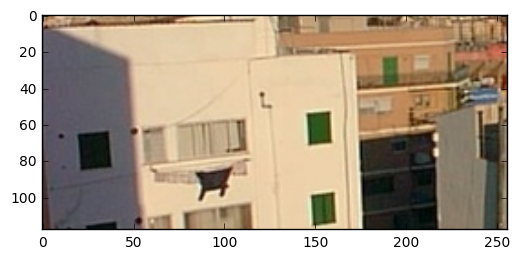

In [9]:
#get negative images, use ratios found for positive images to match
nimages = dg.getRandomMultiple("sun_images", 200, 0)
print len(nimages)
nimages = [x[1] for x in nimages]


nratio0imgs = [dg.cropToRatio(x, ratios[0]) for x in nimages]
nratio1imgs = [dg.cropToRatio(x, ratios[1]) for x in nimages]
nratio2imgs = [dg.cropToRatio(x, ratios[2]) for x in nimages]


print "Number neg imgs at ratio 0:", len(nratio0imgs)
print "Number neg imgs at ratio 1:", len(nratio1imgs)
print "Number neg imgs at ratio 2:", len(nratio2imgs)

plt.imshow(cv2.cvtColor(nratio0imgs[0], cv2.COLOR_BGR2RGB))
plt.show()


Generate features from HOGs and images for each label and aspect ratio

In [10]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data


In [11]:
minDim = 80
HOGs, dims = dg.ratiosToHOGS(ratios, minDim)
print dims


[(80, 32), (80, 88), (80, 56)]


In [12]:
pdata0ratio = getFeaturesWithLabel(pratio0imgs, HOGs[0], dims[0], 1)
pdata1ratio = getFeaturesWithLabel(pratio1imgs, HOGs[1], dims[1], 1)
pdata2ratio = getFeaturesWithLabel(pratio2imgs, HOGs[2], dims[2], 1)

ndata0ratio = getFeaturesWithLabel(nratio0imgs, HOGs[0], dims[0], 0)
ndata1ratio = getFeaturesWithLabel(nratio1imgs, HOGs[1], dims[1], 0)
ndata2ratio = getFeaturesWithLabel(nratio2imgs, HOGs[2], dims[2], 0)

data0ratio = pdata0ratio + ndata0ratio
data1ratio = pdata1ratio + ndata1ratio
data2ratio = pdata2ratio + ndata2ratio

shuffle(data0ratio)
shuffle(data1ratio)
shuffle(data2ratio)

feat0, label0 = map(list, zip(*data0ratio))
feat1, label1 = map(list, zip(*data1ratio))
feat2, label2 = map(list, zip(*data2ratio))

feat0 = [x.flatten() for x in feat0]
feat1 = [x.flatten() for x in feat1]
feat2 = [x.flatten() for x in feat2]

sample_size0 = len(feat0)
sample_size1 = len(feat1)
sample_size2 = len(feat2)

train_size0 = int(round(.8*sample_size0))
train_size1 = int(round(.8*sample_size1))
train_size2 = int(round(.8*sample_size2))



In [13]:
train_feat0 = np.array(feat0[:train_size0], np.float32)
test_feat0 = np.array(feat0[train_size0: sample_size0], np.float32)
train_label0 = np.array(label0[:train_size0])
test_label0 = np.array(label0[train_size0:sample_size0])

train_feat1 = np.array(feat1[:train_size1], np.float32)
test_feat1 = np.array(feat1[train_size1: sample_size1], np.float32)
train_label1 = np.array(label1[:train_size1])
test_label1 = np.array(label1[train_size1:sample_size1])

train_feat2 = np.array(feat2[:train_size2], np.float32)
test_feat2 = np.array(feat2[train_size2: sample_size2], np.float32)
train_label2 = np.array(label2[:train_size2])
test_label2 = np.array(label2[train_size2:sample_size2])

Train SVM

In [14]:
lsvm0 = svm.SVC(gamma=5, C=.1, kernel="linear", probability=True)
lsvm0.fit(train_feat0, train_label0)

lsvm1 = svm.SVC(gamma=5, C=.1, kernel="linear", probability=True)
lsvm1.fit(train_feat1, train_label1)

lsvm2 = svm.SVC(gamma=5, C=.1, kernel="linear", probability=True)
lsvm2.fit(train_feat2, train_label2)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Compute and display training accuracy

In [15]:
print lsvm0.score(train_feat0, train_label0)
print lsvm1.score(train_feat1, train_label1)
print lsvm2.score(train_feat2, train_label2)

0.992610837438
1.0
1.0


Compute and display test set accuracy, true and false positives, true and false negatives, list of files that were misclassified

In [16]:
#compute test accuracy
result0 = lsvm0.predict(test_feat0)
result1 = lsvm1.predict(test_feat1)
result2 = lsvm2.predict(test_feat2)

print "test accuracy aspect ratio 0", lsvm0.score(test_feat0, test_label0)
print "test accuracy aspect ratio 1", lsvm1.score(test_feat1, test_label1)
print "test accuracy aspect ratio 2", lsvm2.score(test_feat2, test_label2)

print
print "first aspect ratio:"
ut.printConfusionMatrix(result0, test_label0)

print "second aspect ratio:"
ut.printConfusionMatrix(result1, test_label1)

print "third aspect ratio:"
ut.printConfusionMatrix(result2, test_label2)


test accuracy aspect ratio 0 0.980392156863
test accuracy aspect ratio 1 1.0
test accuracy aspect ratio 2 1.0

first aspect ratio:
true pos: 59 true neg: 41 false pos: 1 false neg: 1 

second aspect ratio:
true pos: 39 true neg: 43 false pos: 0 false neg: 0 

third aspect ratio:
true pos: 104 true neg: 48 false pos: 0 false neg: 0 



In [17]:
def getHardNegativeFeatures(lsvm, hog, imgDir, imgDir2=None, step=10, scale=1.1):
    #get dataset of negative images to scan through
    negFiles = dg.getAllFiles(imgDir)
    negImgs = []
    falsePos_feat = []
    signs = 0
    nosigns = 0

    for f in negFiles:
        negImgs.append([f, cv2.imread(imgDir + "/" + f)])
    
    if len(negImgs) == 0:
        raise "No images found"
        
    if imgDir2:
        negFiles2 = dg.getAllFiles(imgDir2)
        for f in negFiles2:
            negImgs.append([f, cv2.imread(imgDir2 + "/" + f)])

    #multiscale detect
    counter = 1
    for row in negImgs:
        scales = md.pyramid(row[1], scale, minSize=(30, 30))
        winw = hog.winSize[1]
        winh = hog.winSize[0]

        for img in scales:
            results = []

            for (x, y, window) in md.sliding_window(img, step, (winw, winh)):        
                if window.shape[0] != winh or window.shape[1] != winw:
                    continue
                window = cv2.resize(window, (winh, winw))
                feat = hog.compute(window)
                result = lsvm.predict(feat.reshape(1,-1))[0]
                if result == 1:  
                    falsePos_feat.append(feat)
                    signs +=1
                else:
                    nosigns+=1
        counter +=1

    falsePosFeat = [x.flatten() for x in falsePos_feat] 
    return falsePosFeat

In [18]:
hardNeg0 = getHardNegativeFeatures(lsvm0, HOGs[0], "hwy_empty", step=60, scale=1.5)
print "hard neg on 1st aspect ratio completed"
hardNeg1 = getHardNegativeFeatures(lsvm1, HOGs[1], "hwy_empty", step=60, scale=1.5)
print "hard neg on 2nd aspect ratio completed"
hardNeg2 = getHardNegativeFeatures(lsvm2, HOGs[2], "hwy_empty", step=60, scale=1.5)
print "hard neg on 3rd aspect ratio completed"

print "number of false positives for classifiers", len(hardNeg0), len(hardNeg1), len(hardNeg2)

hard neg on 1st aspect ratio completed
hard neg on 2nd aspect ratio completed
hard neg on 3rd aspect ratio completed
number of false positives for classifiers 9817 1225 3934


In [19]:
#retrain classifiers
hNLabels0 = [0] * len(hardNeg0)
hNLabels1 = [0] * len(hardNeg1)
hNLabels2 = [0] * len(hardNeg2)

if hardNeg0:
    train_features_wfp0 = np.r_[train_feat0, np.array(hardNeg0)]
    train_labels_wfp0 = np.r_[train_label0, np.array(hNLabels0)]
    lsvm0.fit(train_features_wfp0, train_labels_wfp0)
    print "retraining accuracy for ratio 0", lsvm0.score(train_features_wfp0, train_labels_wfp0)
    result0 = lsvm0.predict(test_feat0)
    print "retrain test accuracy aspect ratio 0", lsvm0.score(test_feat0, test_label0)
    print "retrain first aspect ratio:"
    ut.printConfusionMatrix(result0, test_label0)

if hardNeg1:
    train_features_wfp1 = np.r_[train_feat1, np.array(hardNeg1)]
    train_labels_wfp1 = np.r_[train_label1, np.array(hNLabels1)]
    lsvm1.fit(train_features_wfp1, train_labels_wfp1)
    print "retraining accuracy for ratio 1",lsvm1.score(train_features_wfp1, train_labels_wfp1)
    result1 = lsvm1.predict(test_feat1)
    print "retrain test accuracy aspect ratio 1", lsvm1.score(test_feat1, test_label1)
    print "retrain second aspect ratio:"
    ut.printConfusionMatrix(result1, test_label1)
    
if hardNeg2:
    train_features_wfp2 = np.r_[train_feat2, np.array(hardNeg2)]
    train_labels_wfp2= np.r_[train_label2, np.array(hNLabels2)]
    lsvm2.fit(train_features_wfp2, train_labels_wfp2)
    print "retraining accuracy for ratio 2", lsvm2.score(train_features_wfp2, train_labels_wfp2)
    result2 = lsvm2.predict(test_feat2)
    print "retrain test accuracy aspect ratio 2", lsvm2.score(test_feat2, test_label2)
    print "retrain third aspect ratio:"
    ut.printConfusionMatrix(result2, test_label2)




retraining accuracy for ratio 0 0.999413088135
retrain test accuracy aspect ratio 0 0.970588235294
retrain first aspect ratio:
true pos: 58 true neg: 41 false pos: 1 false neg: 2 

retraining accuracy for ratio 1 0.998713826367
retrain test accuracy aspect ratio 1 1.0
retrain second aspect ratio:
true pos: 39 true neg: 43 false pos: 0 false neg: 0 

retraining accuracy for ratio 2 0.999779832673
retrain test accuracy aspect ratio 2 0.986842105263
retrain third aspect ratio:
true pos: 103 true neg: 47 false pos: 1 false neg: 1 



Find and display signs in a test image

In [20]:
def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), x[2] , int(x[3]*factor), int(x[4]*factor)] for x in boxes]

def findSigns(image, hog, lsvm, step=40, scale=1.1, minsize=(20,20), threshold=.5):
    if image is None:
        raise "No image to scan"
    
    winw = hog.winSize[1]
    winh = hog.winSize[0]

    scales = md.pyramid(image, scale, minsize)
    scaled_results = []

    for i, img in enumerate(scales):
        results = []

        for (x, y, window) in md.sliding_window(img, step, (winw, winh)):  
            if window.shape[0] != winh or window.shape[1] != winw:
                continue
            window = cv2.resize(window, hog.winSize)
            feat = hog.compute(window)
            prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
        
            if prob[1] > threshold:
                prediction = [x, y, prob[1], winw, winh]
                results.append(prediction)
        if not results:
            continue
        factor = float(image.shape[0])/img.shape[0]   
        scaled = transform_scale(factor, results)
        scaled_results.extend(scaled)
        
    return scaled_results


In [3]:
def resize(img, scale):
    return cv2.resize(image, (int(image.shape[1]*scale), int(image.shape[0]*scale)))


In [5]:
image = cv2.imread("multiscale_test/1006.jpg")
if image.shape[0] > 400:
    scale = 400.0/image.shape[0]
else: scale = 1
image = resize(image, scale)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
span = 20
thresh = .7
scl = 1.1
scaled_results0 = findSigns(image, HOGs[0], lsvm0, step=span, scale=scl, threshold=thresh)
scaled_results1 = findSigns(image, HOGs[1], lsvm1, step=span, scale=scl, threshold=thresh)
scaled_results2 = findSigns(image, HOGs[2], lsvm2, step=span, scale=scl, threshold=thresh)
results = scaled_results0 + scaled_results1 + scaled_results2


In [70]:
print len(results)
signs = nms.nms(results)
print len(signs)

2
2


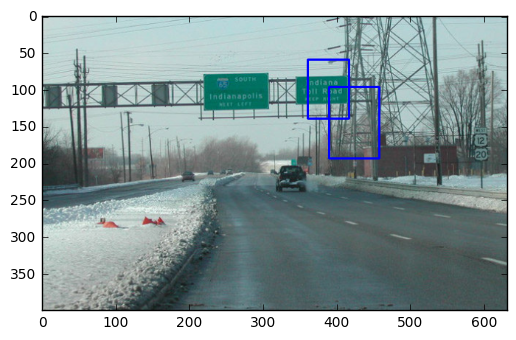

In [72]:
clone = image.copy()
colors = {"green":(0,255,0), "blue": (255,0,0), "black":(0,0,0), "purple":(255,0,255), "red":(0,0,255), "light_blue":(255,165,0), "white":(255,255,255), "gray": (100, 100, 100)}


for i, result in enumerate(signs):
    x1 = result[0]
    y1 = result[1]
    c = result[2]
    x2 = result[3] + x1
    y2 = result[4] + y1
        
        
    if c > .9:
        cv2.rectangle(clone, (x1, y1), (x2, y2), colors["green"], 2)
    elif c > .7:
        cv2.rectangle(clone, (x1, y1), (x2, y2), colors["blue"], 2)
    elif c > .5:
        cv2.rectangle(clone, (x1, y1), (x2, y2), colors["red"], 2)
    elif c > .4:
        cv2.rectangle(clone, (x1, y1), (x2, y2), colors["light_blue"], 2)
    elif c > .3:
        cv2.rectangle(clone, (x1, y1), (x2, y2), colors["gray"], 2)
    elif c > .2:
        cv2.rectangle(clone, (x1, y1), (x2, y2), colors["white"], 2)
    else:
        cv2.rectangle(clone, (x1, y1), (x2, y2), colors["white"], 2)
        
  
    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()